In [1]:
from numba import jit
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import plotly.plotly as py
import plotly.tools as tls
from mpmath import *

%matplotlib inline

mp.dps = 100; mp.pretty = True
euler = +euler
mpl.style.use('classic')
mpl.rc('figure', titlesize=30)
mpl.rc('axes', labelsize=18)
mpl.rc('axes', grid=True)
mpl.rc('grid', linestyle=':')
mpl.rc('legend', fontsize=15)
mpl.rc('figure', figsize=(15, 10))

%load_ext cython

# Costante di Eulero Mascheroni

In questo esercizio vengono confrontati diversi metodi di calcolo e di approssimazione della costante di Eulero-Mascheroni, trattanto l'importanza degli errori dovuti all'approssimazione dell'algoritmo e quelli dovuti alla precisione finita della macchina di calcolo.

La costante di Eulero Mascheroni è definita come
$$
\gamma = \lim_{n \rightarrow +\infty} \sum_k \frac{1}{k} - \log n \\
\gamma = \lim_{n \rightarrow +\infty} (H_n - \ln n)
$$
con 
$$
H_n = \sum_{k=1}^{n} \frac{1}{k}
$$

L'utilizzo della formula diretta è di poco interesse perchè la convergenza della serie è piuttosto lenta. Va come
$$
\frac{1}{2n} \lt  H_n - \log n - \gamma \lt \frac{1}{2n}
$$

## Errori di roundoff

L'aritmetica floating point in python, Java, C, C++, Perl, etc. è descritta dallo standard IEEE-754. Un float viene rappresentato come somma di frazioni i cui denominatori sono potenze in base 2.
Per esempio, 0.125 è rappresentato come 0/2 + 0/4 + 1/8.

In [2]:
x = 0.125
x.as_integer_ratio()

(1, 8)

Il numero .375 invece sarà rappresentato come 0/2 + 1/4 + 1/8 = 3/8

In [3]:
x = 0.375
x.as_integer_ratio()

(3, 8)

Tuttavia, molte frazioni non possono essere espresse in questo modo. Ad esempio, 0.1, per quanto semplice possa sembrare, non è esprimibile come somma finita di frazioni con denominatori in base 2. Di conseguenza viene utilizzato lo standard IEEE per determinare, data la precisione della variabile su cui si sta operando, la frazione con cui rappresentare il numero.

In [4]:
x = 0.1
print(x.as_integer_ratio())
# 36028797018963968 == 2**55 
print(format(x, '.17f'))

(3602879701896397, 36028797018963968)
0.10000000000000001


In un'aritmetica floating point a 64 bit vengono utilizzati 53 bit per la precisione. Il risultato della frazione riportata sopra con tutte le cifre significative è:

In [5]:
from decimal import Decimal
Decimal.from_float(0.1)

Decimal('0.1000000000000000055511151231257827021181583404541015625')

Di conseguenza, quando viene eseguita una sommatoria, gli errori di roundoff tendono ad accumularsi e al crescere del numero di addendi. Nel worst-case scenario l'errore sulla somma cresce come n ma esistono degli algoritmi come quello di [Kahan](https://en.wikipedia.org/wiki/Kahan_summation_algorithm) che permettono di ottenere un errore con un ordine di grandezza della precisione della variabile e indipendente dal numero di addendi

Supponiamo di conoscere con precisione di n=100 cifre la costante di Eulero-Mascheroni. Calcoliamo come nella definizione sopra e osserviamo il valore dell'errore al variare di n

In [6]:
%%cython
from math import log

cpdef euler_constant(int n):
    cdef float Hn = 0
    cdef float lnn = log(n)
    for k in range(1, n + 1):
        Hn += 1 / k
        
    return Hn - lnn

cpdef euler_constant_double_precision(int n):
    cdef double Hn = 0
    cdef double lnn = log(n)
    for k in range(1, n + 1):
        Hn += 1 / k
        
    return Hn - lnn

cpdef euler_constant_kahan_sum(int n):
    cdef float Hn = 0
    cdef float lnn = log(n)
    cdef c = 0
    cdef float y = 0
    cdef float t = 0
    for k in range(1, n + 1):
        # 3. Il resto lo prendo dalle iterazioni precedenti e lo sommo
        y = (1 / k) - c 
        # 1. Hn sarà un numero sempre più grande, mentre y è un numero piccolo. 
        #    Quindi perdo le cifre meno significative di y
        t = Hn + y 
        # 2. (t - Hn) cancella le cifre più significative di y e quindi c avrà
        #    le cifre meno significative che si sommano al ciclo dopo
        c = (t - Hn) - y 
        Hn = t
    
    return Hn - lnn

In [7]:
p = Pool(4)
n = np.logspace(1, 8, num=40)
results1 = np.array(p.map(euler_constant, n))
results2 = np.array(p.map(euler_constant_kahan_sum, n))
results3 = np.array(p.map(euler_constant_double_precision, n))

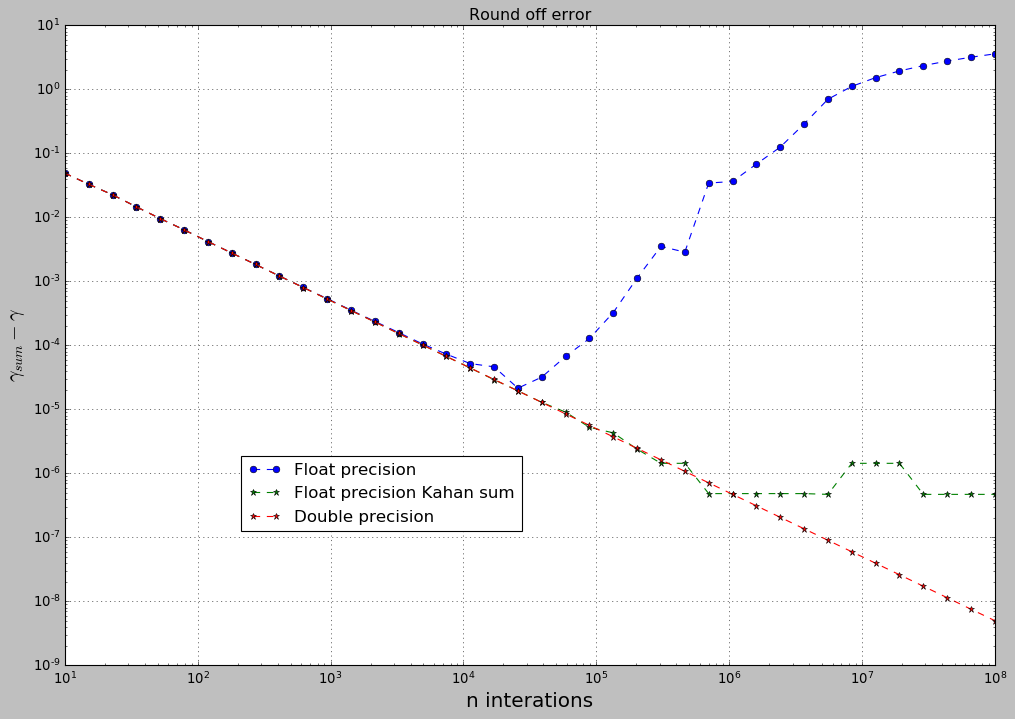

In [8]:
plt.loglog(n, np.abs(results1 - euler), 'o--', label='Float precision')
plt.loglog(n, np.abs(results2 - euler), '*--', label='Float precision Kahan sum')
plt.loglog(n, np.abs(results3 - euler), '*--', label='Double precision')
plt.title('Round off error')
plt.xlabel('n interations')
plt.ylabel('$\\gamma_{sum}  - \\gamma$')
plt.legend(bbox_to_anchor=(0.5, .34))

Come si può osservare dal grafico, utilizzando semplicemente la definizione di limite e applicando una sommatoria con un aritmetica float a precisione singola, l'algoritmo inizia a produrre errori di roundoff che esplodono quando il numero di addendi arriva a $n = 10^4$ e quando la differenza tra il valore reale e il valore calcolato arriva a $10^5$. Ciò significa che la massima precisione ottenuta ha un valore limite di 5 cifre decimali.

Utilizzando la sommatoria di Kahan è possibile tenere sotto controllo gli errori di roundoff salvandoli in una variabile (`c` nel presente caso) e vengono sommati all'iterazione successiva. Ciò permette di arrivare a $n \approx 10^6$ iterazioni con un errore di $10^{-6}$ che implica una precisione di 6 cifre, come definito dallo standard IEEE-754 per i float. Quindi è possibile raggiungere la massima precisione tenendo sotto controllo gli errori.

Il valore double continua a decrescere perchè il numero di cifre significative arriva fino a 15–17. Bisognerebbe calcolare il valore della costante di mascheroni con almeno $n\approx 10^{14}-10^{15}$ ma l'algoritmo non è molto efficiente e la sua espressione in termini di serie ha una convergenza piuttosto lenta (va come $1/2n$). 

Di conseguenza è anche utile studiare dei modi alternativi per calcolare la costante. Utilizzando delle serie diverse la convergenza può essere più o meno veloce.

## Convergenza delle serie

è possibile dimostrare che applicando la definizione della costante di eulero mascheroni la sua convergenza è tale per cui:
$$
\frac{1}{2n} \lt  H_n - \log n - \gamma \lt \frac{1}{2n} \quad \text{Young}
$$
Tale convergenza è dovuta a Young. Scrivendo quindi un algoritmo che utilizza questa serie è difficile ottenere efficientemente valori ad alta precisione di $\gamma$.

Tuttavia esistono anche altre identità che portano ad ottenere risultati più semplici e veloci:
$$
0 \lt H_n - \frac{\log(n) + \log(n+1)}{2} - \gamma \lt \frac{1}{6n(n+1)} \qquad \text{Cesaro}
$$
$$
-\frac{1}{48 n^3} \lt H_n - \log \big(n + \frac{1}{2} + \frac{1}{24 n} \big) - \gamma \lt -\frac{1}{48 (n+1)^3} \qquad
\text{Negoi}
$$

In [9]:
%%cython
from math import log

# Calcolo della serie armonica
cpdef long double Hn(int n):
    cdef long double Hn = 0
    cdef int k
    for k in range(1, n+1):
        Hn += 1 / k
        
    return Hn

# Calcolo della serie armonica con somma di Kahan
cpdef long double Hn_kahan_sum(int n):
    cdef long double Hn = 0
    cdef c = 0
    cdef long double y = 0
    cdef long double t = 0
    cdef int k
    for k in range(1, n + 1):
        y = (1 / k) - c 
        t = Hn + y 
        c = (t - Hn) - y 
        Hn = t
    
    return Hn

# Va come 1/2n
cpdef long double euler_constant_young(int n):
    cdef long double difference = log(n)
    cdef long double sums = Hn(n)
    
    return sums - difference

# Va come 1/n^2
cpdef long double euler_constant_cesaro(int n):
    cdef long double difference = (log(n) + log(n + 1)) / 2
    cdef long double sums = Hn(n)
    
    return sums - difference

# Va come 1/n^3
cpdef long double euler_constant_negoi(int n):
    cdef long double difference = log(n + 1/2. + 1/(24. * n))
    cdef long double sums = Hn(n)
    
    return sums - difference

# Tentativo di ridurre gli errori di roundoff
cpdef long double euler_constant_negoi_kahan(int n):
    cdef long double difference = log(n + 1/2. + 1/(24. * n))
    cdef long double sums = Hn_kahan_sum(n)
    
    return sums - difference

In [10]:
p = Pool(4)
n = np.logspace(1, 8, num=10)
# Genera una sequenza 
young = np.array(p.map(euler_constant_young, n))
negoi = np.array(p.map(euler_constant_negoi, n))
negoi_kahan = np.array(p.map(euler_constant_negoi_kahan, n))
cesaro = np.array(p.map(euler_constant_cesaro, n))

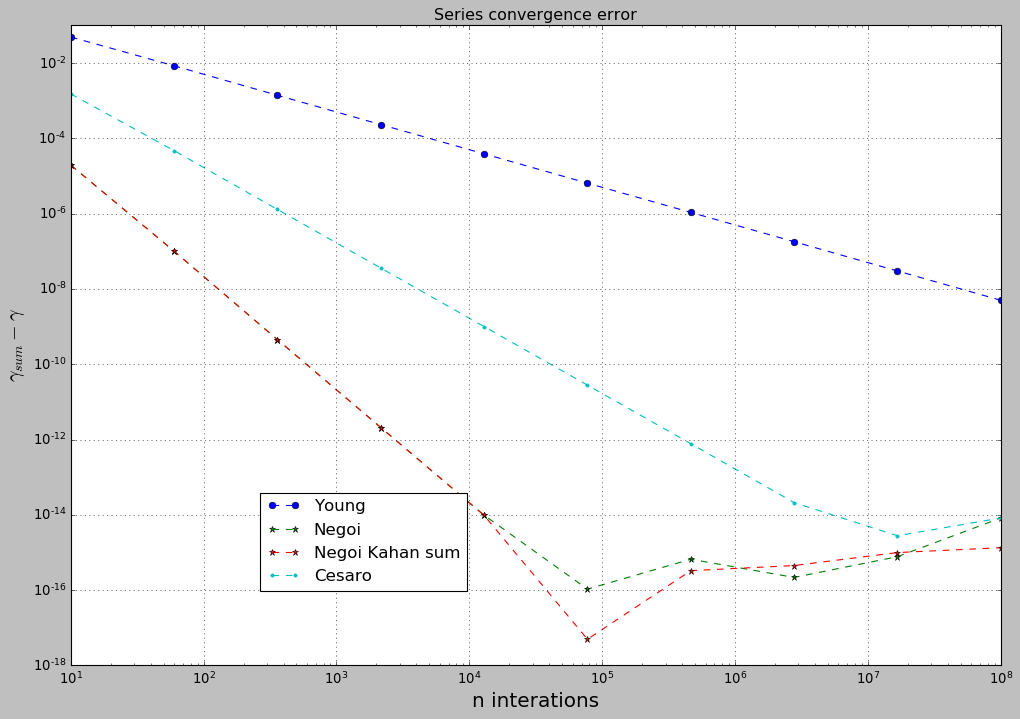

In [11]:
plt.figure()
plt.loglog(n, np.abs(young - euler), 'o--', label='Young')
plt.loglog(n, np.abs(negoi - euler), '*--', label='Negoi')
plt.loglog(n, np.abs(negoi_kahan - euler), '*--', label='Negoi Kahan sum')
plt.loglog(n, np.abs(cesaro - euler), '.--', label='Cesaro')
plt.title('Series convergence error')
plt.xlabel('n interations')
plt.ylabel('$\\gamma_{sum}  - \\gamma$')
plt.legend(bbox_to_anchor=(0.435, .283))
# plt.yscale('log')

Dalla figura sopra si possono osservare i comportamenti asintitoci della convergenza delle serie. I diversi coefficienti angolari indicano una diversa potenza con cui la serie di avvicina al valore della costante $\gamma$. Si può anche osservare come la serie di Negoi sia quella con un minore errore algoritmico. Ciò è dovuto al fatto che tra le diverse approssimazioni è quella che converge più velocemente. Quando il numero di iterazione arriva a $n \approx 10^5$ gli errori di aritmetica con precisione double prevalgono.